In [1]:
import numpy as np
import pandas as pd
import os

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, VotingClassifier
import xgboost as xgb
from sklearn import svm
from sklearn.pipeline import make_pipeline

from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay, roc_curve, roc_auc_score
from sklearn.calibration import calibration_curve
from sklearn.preprocessing import StandardScaler, LabelEncoder

In [2]:
def plot_confusion_matrix(y_test, y_hat, model, class_names):
    cm = confusion_matrix(y_test, y_hat, labels=model.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                  display_labels=class_names)
    disp.plot()
    plt.rcParams["font.size"] = "11"
    plt.xlabel('Predicted label', fontsize=14)
    plt.ylabel('True label', fontsize=14)
    plt.show()

In [3]:
# Set up folder with data:
os.chdir('D:\\00_PROJECTS_sripts_code\\Credit_Risk')

In [4]:
###################
#%% Read data
###################

In [5]:
analysis_data = pd.read_csv('analysis_data.csv')                          

In [6]:
### Select all numerical and string variables:
numeric_columns = analysis_data.select_dtypes(exclude=['object']).columns
categorical_columns = analysis_data.select_dtypes(include=['object']).columns

In [7]:
##########################################################
##########################################################
#%% Analysis data - prepare for analysis
##########################################################
##########################################################

In [8]:
###################
#%% Corellations plot - heatmap
###################

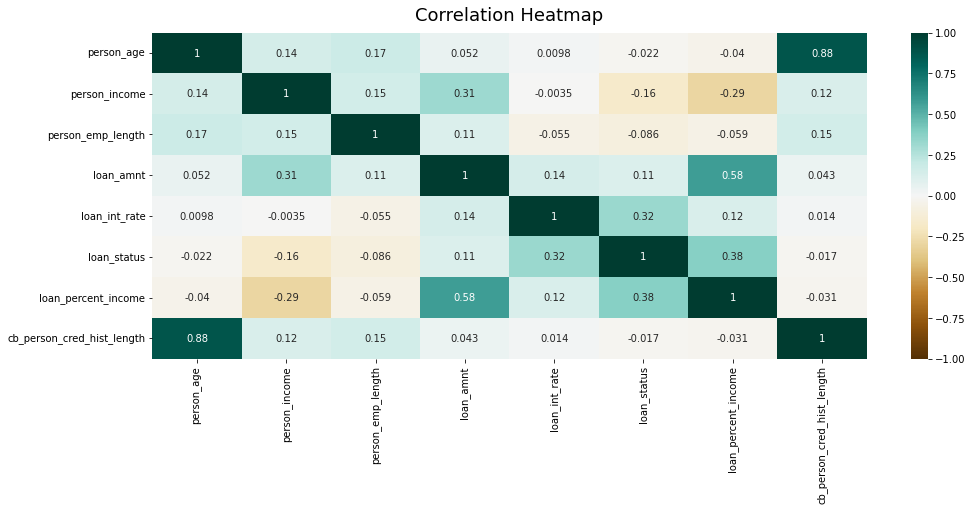

In [9]:
# with values and colors with divergence map
plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(analysis_data[numeric_columns].corr(), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':18}, pad=12);

In [10]:
##########################################################
#%% Label encoding the non-numeric columns

In [11]:
labelencoder = LabelEncoder()

# apply "le.fit_transform"
analysis_data = analysis_data.apply(labelencoder.fit_transform)
print(analysis_data.columns)

Index(['person_age', 'person_income', 'person_home_ownership',
       'person_emp_length', 'loan_intent', 'loan_grade', 'loan_amnt',
       'loan_int_rate', 'loan_status', 'loan_percent_income',
       'cb_person_default_on_file', 'cb_person_cred_hist_length'],
      dtype='object')


In [12]:
##########################################################
#%% Train-Test Set

In [13]:
X = analysis_data.drop('loan_status', axis=1)
y = analysis_data[['loan_status']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)
# stratify=y garantie the same 'y' distribution

In [14]:
##########################################################
#%% Undersampling training data

In [15]:
X_y_train = pd.concat([X_train.reset_index(drop = True),
                       y_train.reset_index(drop = True)], axis = 1)
count_nondefault, count_default = X_y_train['loan_status'].value_counts()

In [16]:
print(count_nondefault, count_default)

19883 5460


In [17]:
# Create data sets for defaults and non-defaults
nondefaults = X_y_train.query('loan_status == 0')
defaults = X_y_train.query('loan_status == 1')

# Undersample the non-defaults
nondefaults_under = nondefaults.sample(count_default)

# Concatenate the undersampled nondefaults with defaults
X_y_train_under = pd.concat([nondefaults_under.reset_index(drop=True), defaults.reset_index(drop=True)], axis = 0)

# Print the value counts for loan status
print(X_y_train_under['loan_status'].value_counts())

loan_status
0    5460
1    5460
Name: count, dtype: int64


In [18]:
X_train = X_y_train_under.drop('loan_status', axis=1)
y_train = X_y_train_under[['loan_status']]

In [19]:
##########################################################
#%% scale data for some models

In [20]:
X_train_sld = StandardScaler().fit(X_train).transform(X_train.astype(float))
X_test_sld = StandardScaler().fit(X_test).transform(X_test.astype(float))

In [21]:
##########################################################
##########################################################
#%% Logistic Regression
##########################################################
##########################################################

In [22]:
##########################################################
#%% Train model - hyperparameter tunning
##########################################################

In [23]:
# Define parameters set
lr_param_grid = { 'C': np.logspace(-5, 8, 15)
                 , 'penalty': ['l1', 'l2']
                 }

# Instantiate model
model_lr_init = LogisticRegression(solver = 'liblinear')

## in case of GridSeach:  param_grid no param_distributions

# Perform random search with CV for time series

#
model_lr_random_search = RandomizedSearchCV(param_distributions = lr_param_grid,
                                              estimator = model_lr_init,
                                              scoring = 'roc_auc',
                                              n_iter = 50,
                                              cv = 5,
                                              verbose=1,
                                              n_jobs=None)

## in case of GridSeach:  param_grid no param_distributions

# Fit randomized_mse to the data
model_lr_random_search.fit(X_train, np.ravel(y_train))

# Print the best parameters
print("Best parameters found: ", model_lr_random_search.best_params_)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


C:\Users\kamil\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:307: UserWarning: The total space of parameters 30 is smaller than n_iter=50. Running 30 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best parameters found:  {'penalty': 'l2', 'C': 163789.3706954068}


In [24]:
# Extract the best model
model_lr = model_lr_random_search.best_estimator_

In [25]:
##########################################################
#%% Test set - model evaluation
##########################################################

In [26]:
preds_proba_lr = model_lr.predict_proba(X_test)

              precision    recall  f1-score   support

 Non-Default       0.93      0.77      0.84      4971
     Default       0.49      0.79      0.60      1365

    accuracy                           0.77      6336
   macro avg       0.71      0.78      0.72      6336
weighted avg       0.83      0.77      0.79      6336


AUC score:   0.862

Confusion Matrix:


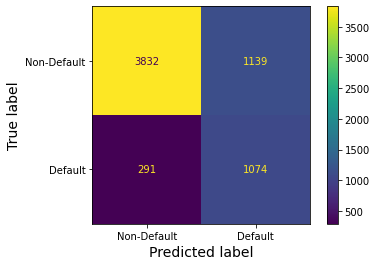

In [27]:
# Create a dataframe for the probabilities of default
preds_df_lr = pd.DataFrame(preds_proba_lr[:,1], columns = ['prob_default'])

# Reassign loan status based on the threshold
preds_df_lr['loan_status'] = preds_df_lr['prob_default'].apply(lambda x: 1 if x > 0.5 else 0)

# Print the classification report
target_names = ['Non-Default', 'Default']
print(classification_report(y_test, preds_df_lr['loan_status'], target_names=target_names))

### AUC score
print('')
print('AUC score:   ' + str(round(roc_auc_score(y_test, preds_df_lr['prob_default']), 3) ) )

### Confusion Matrix
print('')
print('Confusion Matrix:')
plot_confusion_matrix(y_test, preds_df_lr['loan_status'], model_lr, target_names)

In [28]:
##########################################################
##########################################################
#%% kNN
##########################################################
##########################################################

In [29]:
##########################################################
#%% Train model - hyperparameter tunning
##########################################################

In [30]:
# Define parameters set
knn_param_grid = { 'n_neighbors' : [15,17,19,21, 23, 25, 27, 29, 31, 33, 35, 37],
                   'weights' : ['uniform','distance'],
                   'metric' : ['minkowski','euclidean','manhattan']}

# Instantiate model
model_knn_init = KNeighborsClassifier()

## in case of GridSeach:  param_grid no param_distributions

# Perform random search with CV for time series

#
model_knn_random_search = RandomizedSearchCV(param_distributions = knn_param_grid,
                                              estimator = model_knn_init,
                                              scoring = 'roc_auc',
                                              n_iter = 50,
                                              cv = 5,
                                              verbose=1,
                                              n_jobs=-1)

## in case of GridSeach:  param_grid no param_distributions

# Fit randomized_mse to the data
model_knn_random_search.fit(X_train_sld, np.ravel(y_train))

# Print the best parameters
print("Best parameters found: ", model_knn_random_search.best_params_)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best parameters found:  {'weights': 'distance', 'n_neighbors': 37, 'metric': 'manhattan'}


In [31]:
# Extract the best model
model_knn = model_knn_random_search.best_estimator_

In [32]:
##########################################################
#%% Test set - model evaluation
##########################################################

In [33]:
preds_proba_knn = model_knn.predict_proba(X_test_sld)

              precision    recall  f1-score   support

 Non-Default       0.95      0.71      0.81      4971
     Default       0.45      0.86      0.59      1365

    accuracy                           0.74      6336
   macro avg       0.70      0.78      0.70      6336
weighted avg       0.84      0.74      0.76      6336


AUC score:   0.883

Confusion Matrix:


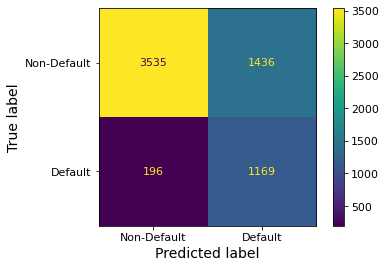

In [34]:
# Create a dataframe for the probabilities of default
preds_df_knn = pd.DataFrame(preds_proba_knn[:,1], columns = ['prob_default'])

# Reassign loan status based on the threshold
preds_df_knn['loan_status'] = preds_df_knn['prob_default'].apply(lambda x: 1 if x > 0.5 else 0)

# Print the classification report
target_names = ['Non-Default', 'Default']
print(classification_report(y_test, preds_df_knn['loan_status'], target_names=target_names))

### AUC score
print('')
print('AUC score:   ' + str(round(roc_auc_score(y_test, preds_df_knn['prob_default']), 3) ) )

### Confusion Matrix
print('')
print('Confusion Matrix:')
plot_confusion_matrix(y_test, preds_df_knn['loan_status'], model_knn, target_names)

In [35]:
##########################################################
##########################################################
#%% AdaBoost
##########################################################
##########################################################

In [36]:
# Define parameters set
AdaBoost_param_grid = { 'estimator__min_samples_split':[5,6,7,8,9]
                       ,'estimator__min_samples_leaf':[2,3,4,5,6,7, 8, 9]
                       ,'estimator__max_depth':[2, 3,4,5,6, 7]
                       ,'n_estimators': [ 200, 250, 300, 350, 400, 450, 500]
                       ,'learning_rate':[0.01, 0.05, 0.1, 0.3, 0.6, 0.9]}


# Instantiate model
dt_base_learner = DecisionTreeClassifier()
model_AdaBoost_init = AdaBoostClassifier(estimator = dt_base_learner)

## in case of GridSeach:  param_grid no param_distributions

# Perform random search with CV for time series

#
model_AdaBoost_random_search = RandomizedSearchCV(param_distributions = AdaBoost_param_grid,
                                              estimator = model_AdaBoost_init,
                                              scoring = 'roc_auc',
                                              n_iter = 50,
                                              cv = 5,
                                              verbose=1,
                                              n_jobs=-1)

## in case of GridSeach:  param_grid no param_distributions

# Fit randomized_mse to the data
model_AdaBoost_random_search.fit(X_train, np.ravel(y_train))

# Print the best parameters
print("Best parameters found: ", model_AdaBoost_random_search.best_params_)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best parameters found:  {'n_estimators': 200, 'learning_rate': 0.1, 'estimator__min_samples_split': 7, 'estimator__min_samples_leaf': 7, 'estimator__max_depth': 3}


In [37]:
# Extract the best model
model_AdaBoost = model_AdaBoost_random_search.best_estimator_

In [38]:
##########################################################
#%% Test set - model evaluation
##########################################################

In [39]:
preds_proba_AdaBoost = model_AdaBoost.predict_proba(X_test)

              precision    recall  f1-score   support

 Non-Default       0.95      0.94      0.94      4971
     Default       0.78      0.81      0.80      1365

    accuracy                           0.91      6336
   macro avg       0.87      0.88      0.87      6336
weighted avg       0.91      0.91      0.91      6336


AUC score:   0.948

Confusion Matrix:


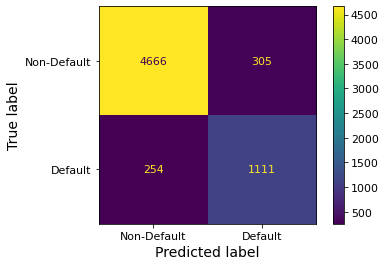

In [40]:
# Create a dataframe for the probabilities of default
preds_df_AdaBoost = pd.DataFrame(preds_proba_AdaBoost[:,1], columns = ['prob_default'])

# Reassign loan status based on the threshold
preds_df_AdaBoost['loan_status'] = preds_df_AdaBoost['prob_default'].apply(lambda x: 1 if x > 0.5 else 0)

# Print the classification report
target_names = ['Non-Default', 'Default']
print(classification_report(y_test, preds_df_AdaBoost['loan_status'], target_names=target_names))

### AUC score
print('')
print('AUC score:   ' + str(round(roc_auc_score(y_test, preds_df_AdaBoost['prob_default']), 3) ) )

### Confusion Matrix
print('')
print('Confusion Matrix:')
plot_confusion_matrix(y_test, preds_df_AdaBoost['loan_status'], model_AdaBoost, target_names)

In [41]:
##########################################################
##########################################################
#%% XGBoost
##########################################################
##########################################################

In [42]:
# Define parameters set
xgboost_param_grid = {
                  'n_estimators': [  200, 250,  300, 350, 400, 450, 500],
                  'max_depth': range(2, 9),
                  'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
                  'colsample_bytree': [0.3, 0.5, 0.7, 0.9, 1.0],
                  'learning_rate': [ 0.01, 0.05, 0.1, 0.3, 0.5, 0.7],
                  'gamma': [0, 0.25, 0.5, 1.0, 1.5, 2.0, 2.5],
                  'reg_lambda': [0.01, 0.05, 0.1, 0.3, 0.5, 0.75, 1.0],
                  'min_child_weight':[0.01, 0.05, 0.1, 1, 3]
                 }

# Instantiate model
model_xgboost_init = xgb.XGBClassifier()

## in case of GridSeach:  param_grid no param_distributions

# Perform random search with CV for time series

# roc_auc, recall, f1_macro
model_xgboost_random_search = RandomizedSearchCV(param_distributions = xgboost_param_grid,
                                                  estimator = model_xgboost_init,
                                                  scoring = 'roc_auc',
                                                  n_iter = 50,
                                                  cv = 5,
                                                  verbose=1,
                                                  n_jobs=-1)

## in case of GridSeach:  param_grid no param_distributions

# Fit randomized_mse to the data
model_xgboost_random_search.fit(X_train, np.ravel(y_train))

# Print the best parameters
print("Best parameters found: ", model_xgboost_random_search.best_params_)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best parameters found:  {'subsample': 1.0, 'reg_lambda': 0.05, 'n_estimators': 300, 'min_child_weight': 0.05, 'max_depth': 6, 'learning_rate': 0.05, 'gamma': 2.0, 'colsample_bytree': 0.7}


In [43]:
# Extract the best model
model_xgboost = model_xgboost_random_search.best_estimator_

In [44]:
##########################################################
#%% Test set - model evaluation
##########################################################

In [45]:
preds_proba_xgboost = model_xgboost.predict_proba(X_test)

              precision    recall  f1-score   support

 Non-Default       0.95      0.93      0.94      4971
     Default       0.78      0.84      0.81      1365

    accuracy                           0.91      6336
   macro avg       0.87      0.89      0.88      6336
weighted avg       0.92      0.91      0.91      6336


AUC score:   0.954

Confusion Matrix:


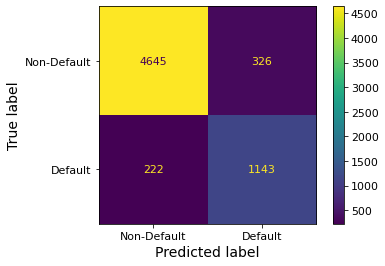

In [46]:
# Create a dataframe for the probabilities of default
preds_df_xgboost = pd.DataFrame(preds_proba_xgboost[:,1], columns = ['prob_default'])

# Reassign loan status based on the threshold
preds_df_xgboost['loan_status'] = preds_df_xgboost['prob_default'].apply(lambda x: 1 if x > 0.5 else 0)

# Print the classification report
target_names = ['Non-Default', 'Default']
print(classification_report(y_test, preds_df_xgboost['loan_status'], target_names=target_names))

### AUC score
print('')
print('AUC score:   ' + str(round(roc_auc_score(y_test, preds_df_xgboost['prob_default']), 3) ) )

### Confusion Matrix
print('')
print('Confusion Matrix:')
plot_confusion_matrix(y_test, preds_df_xgboost['loan_status'], model_xgboost, target_names)

In [47]:
##########################################################
##########################################################
#%% SVM
##########################################################
##########################################################

In [48]:
# Define parameters set
svm_param_grid = {
                  #'kernel': ['rbf','poly','sigmoid'],
                  'kernel': ['rbf'],
                  'C': [ 100, 1000, 3000, 5000, 7000, 9000],
                  'gamma': [0.001, 0.005, 0.01,  0.05],
                  #'epsilon': [0.5, 0.3, 0.1, 0.08],
                  #'degree':[3,4,5]
                 }

# Instantiate model
model_svm_init = svm.SVC(probability=True)

## in case of GridSeach:  param_grid no param_distributions

# Perform random search with CV for time series

#
model_svm_random_search = RandomizedSearchCV(param_distributions = svm_param_grid,
                                              estimator = model_svm_init,
                                              scoring = 'roc_auc',
                                              n_iter = 50,
                                              cv = 5,
                                              verbose=1,
                                              n_jobs=-1)

## in case of GridSeach:  param_grid no param_distributions

# Fit randomized_mse to the data
model_svm_random_search.fit(X_train_sld, np.ravel(y_train))

# Print the best parameters
print("Best parameters found: ", model_svm_random_search.best_params_)

C:\Users\kamil\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:307: UserWarning: The total space of parameters 24 is smaller than n_iter=50. Running 24 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best parameters found:  {'kernel': 'rbf', 'gamma': 0.01, 'C': 3000}


In [49]:
# Extract the best model
model_svm = model_svm_random_search.best_estimator_

In [50]:
##########################################################
#%% Test set - model evaluation
##########################################################

In [51]:
preds_proba_svm = model_svm.predict_proba(X_test_sld)

              precision    recall  f1-score   support

 Non-Default       0.95      0.72      0.82      4971
     Default       0.46      0.85      0.59      1365

    accuracy                           0.75      6336
   macro avg       0.70      0.79      0.71      6336
weighted avg       0.84      0.75      0.77      6336


AUC score:   0.886

Confusion Matrix:


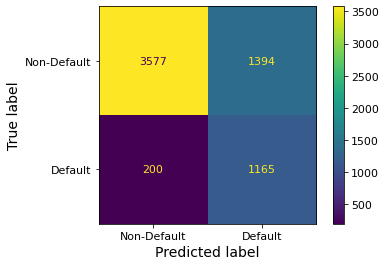

In [52]:
# Create a dataframe for the probabilities of default
preds_df_svm = pd.DataFrame(preds_proba_svm[:,1], columns = ['prob_default'])

# Reassign loan status based on the threshold
preds_df_svm['loan_status'] = preds_df_svm['prob_default'].apply(lambda x: 1 if x > 0.5 else 0)

# Print the classification report
target_names = ['Non-Default', 'Default']
print(classification_report(y_test, preds_df_svm['loan_status'], target_names=target_names))

### AUC score
print('')
print('AUC score:   ' + str(round(roc_auc_score(y_test, preds_df_svm['prob_default']), 3) ) )

### Confusion Matrix
print('')
print('Confusion Matrix:')
plot_confusion_matrix(y_test, preds_df_svm['loan_status'], model_svm, target_names)

In [53]:
##########################################################
##########################################################
#%% Voting Classifier
##########################################################
##########################################################

In [54]:
# Define the list classifiers
classifiers = [('Logistic Regression', LogisticRegression(solver = 'liblinear', **model_lr_random_search.best_params_)),\
               ('K Nearest Neighbours', KNeighborsClassifier(**model_knn_random_search.best_params_)),\
               ('SVM', make_pipeline(StandardScaler(),svm.SVC(probability=True, **model_svm_random_search.best_params_))),\
               ('XGBoost', xgb.XGBClassifier(**model_xgboost_random_search.best_params_))]

In [55]:
# Instantiate a VotingClassifier vc
model_voting = VotingClassifier(estimators=classifiers, voting='soft')

In [56]:
model_voting.fit(X_train, np.ravel(y_train))

VotingClassifier(estimators=[('Logistic Regression',
                              LogisticRegression(C=163789.3706954068,
                                                 solver='liblinear')),
                             ('K Nearest Neighbours',
                              KNeighborsClassifier(metric='manhattan',
                                                   n_neighbors=37,
                                                   weights='distance')),
                             ('SVM',
                              Pipeline(steps=[('standardscaler',
                                               StandardScaler()),
                                              ('svc',
                                               SVC(C=3000, gamma=0.01,
                                                   probability=True))])),
                             ('XGBoost',
                              XGBClassifier(base_s...
                                            gpu_id=None, grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=0.05, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=6,
                                            max_leaves=None,
                                            min_child_weight=0.05, missing=nan,
                                            monotone_constraints=None,
                                            n_estimators=300, n_jobs=None,
                                            num_parallel_tree=None,
                                            predictor=None, random_state=None, ...))],
                 voting='soft')

In [57]:
preds_proba_voting = model_voting.predict_proba(X_test)

              precision    recall  f1-score   support

 Non-Default       0.95      0.88      0.91      4971
     Default       0.65      0.83      0.73      1365

    accuracy                           0.87      6336
   macro avg       0.80      0.85      0.82      6336
weighted avg       0.89      0.87      0.87      6336


AUC score:   0.931

Confusion Matrix:


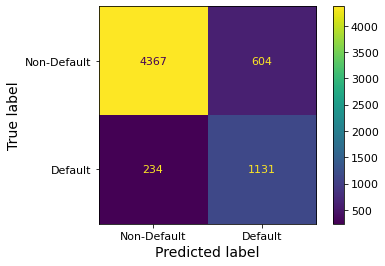

In [58]:
# Create a dataframe for the probabilities of default
preds_df_voting = pd.DataFrame(preds_proba_voting[:,1], columns = ['prob_default'])

# Reassign loan status based on the threshold
preds_df_voting['loan_status'] = preds_df_voting['prob_default'].apply(lambda x: 1 if x > 0.5 else 0)


# Print the classification report
target_names = ['Non-Default', 'Default']
print(classification_report(y_test, preds_df_voting['loan_status'], target_names=target_names))

### AUC score
print('')
print('AUC score:   ' + str(round(roc_auc_score(y_test, preds_df_voting['prob_default']), 3) ) )

### Confusion Matrix
print('')
print('Confusion Matrix:')
plot_confusion_matrix(y_test, preds_df_voting['loan_status'], model_voting, target_names)

In [59]:
##########################################################
##########################################################
#%% COMPARE MODELS
##########################################################
##########################################################

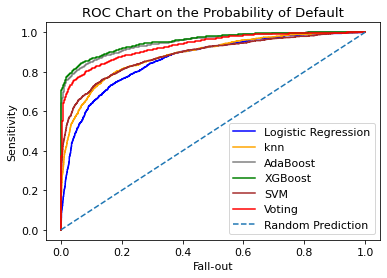

In [60]:
# ROC chart components
fallout_lr, sensitivity_lr, thresholds_lr = roc_curve(y_test, preds_df_lr['prob_default'])
fallout_knn, sensitivity_knn, thresholds_knn = roc_curve(y_test, preds_df_knn['prob_default'])
fallout_AdaBoost, sensitivity_AdaBoost, thresholds_AdaBoost = roc_curve(y_test, preds_df_AdaBoost['prob_default'])
fallout_xgboost, sensitivity_xgboost, thresholds_xgboost = roc_curve(y_test, preds_df_xgboost['prob_default'])
fallout_svm, sensitivity_svm, thresholds_svm = roc_curve(y_test, preds_df_svm['prob_default'])
fallout_voting, sensitivity_voting, thresholds_voting = roc_curve(y_test, preds_df_voting['prob_default'])


# ROC Chart with both
plt.plot(fallout_lr, sensitivity_lr, color = 'blue', label='%s' % 'Logistic Regression')
plt.plot(fallout_knn, sensitivity_knn, color = 'orange', label='%s' % 'knn')
plt.plot(fallout_AdaBoost, sensitivity_AdaBoost, color = 'grey', label='%s' % 'AdaBoost')
plt.plot(fallout_xgboost, sensitivity_xgboost, color = 'green', label='%s' % 'XGBoost')
plt.plot(fallout_svm, sensitivity_svm, color = 'brown', label='%s' % 'SVM')
plt.plot(fallout_voting, sensitivity_voting, color = 'red', label='%s' % 'Voting')

plt.plot([0, 1], [0, 1], linestyle='--', label='%s' % 'Random Prediction')
plt.title("ROC Chart on the Probability of Default")
plt.xlabel('Fall-out')
plt.ylabel('Sensitivity')
plt.legend()
plt.show()

In [61]:
# Calibration curve

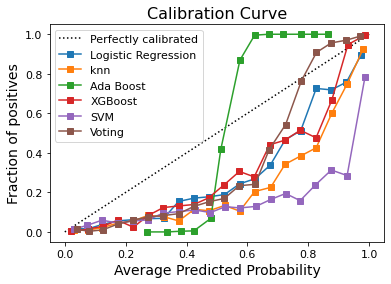

In [62]:
frac_of_pos_lr, mean_pred_val_lr = calibration_curve(y_test, preds_df_lr['prob_default'], n_bins=20)
frac_of_pos_knn, mean_pred_val_knn = calibration_curve(y_test, preds_df_knn['prob_default'], n_bins=20)
frac_of_pos_AdaBoost, mean_pred_val_AdaBoost = calibration_curve(y_test, preds_df_AdaBoost['prob_default'], n_bins=20)
frac_of_pos_xgboost, mean_pred_val_xgboost = calibration_curve(y_test, preds_df_xgboost['prob_default'], n_bins=20)
frac_of_pos_svm, mean_pred_val_svm = calibration_curve(y_test, preds_df_svm['prob_default'], n_bins=20)
frac_of_pos_voting, mean_pred_val_voting = calibration_curve(y_test, preds_df_voting['prob_default'], n_bins=20)


plt.plot([0, 1], [0, 1], 'k:', label='Perfectly calibrated')    
plt.plot(mean_pred_val_lr, frac_of_pos_lr, 's-', label='%s' % 'Logistic Regression')
plt.plot(mean_pred_val_knn, frac_of_pos_knn, 's-', label='%s' % 'knn')
plt.plot(mean_pred_val_AdaBoost, frac_of_pos_AdaBoost, 's-', label='%s' % 'Ada Boost')
plt.plot(mean_pred_val_xgboost, frac_of_pos_xgboost, 's-', label='%s' % 'XGBoost')
plt.plot(mean_pred_val_svm, frac_of_pos_svm, 's-', label='%s' % 'SVM')
plt.plot(mean_pred_val_voting, frac_of_pos_voting, 's-', label='%s' % 'Voting')

plt.ylabel('Fraction of positives', fontsize=14)
plt.xlabel('Average Predicted Probability', fontsize=14)
plt.legend()
plt.title('Calibration Curve', fontsize=16)
plt.show()